##  Classification : SVC

### Business Objective

    To identify products at risk of backorder before the event occurs so the business has time to react. 

#### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.
    
         Yes or 1 : Product backordered

         No or 0  : Product not backordered

#### Identify Right Error Metrics

    Based on the businees have to identify right error metrics.

#### Loading the required libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#### Loading the data

In [2]:
data = pd.read_csv("BackOrders.csv",skiprows=4,na_values=['$','#','Null'],nrows=10000)

#### See the No. row and columns

In [3]:
data.shape

(10000, 23)

#### See the sample data

In [4]:
data.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,NaN,NaN,0.0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7.0,2.0,0.0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258.0,15.0,10.0,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46.0,2.0,0.0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2.0,2.0,0.0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No


In [5]:
data.tail()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
9995,1707127,24.0,3.0,0.0,20,40,80,9,27,64,...,0,0.52,0.41,0,No,No,No,Yes,No,No
9996,1685040,8.0,8.0,0.0,0,0,0,2,2,3,...,0,0.86,0.88,0,No,No,No,Yes,No,No
9997,2021141,3102.0,8.0,978.0,8991,15777,22581,611,1861,3535,...,0,0.98,0.99,0,No,No,No,Yes,No,No
9998,1212465,5.0,2.0,0.0,0,0,0,0,0,1,...,0,0.48,0.53,0,Yes,No,No,Yes,No,No
9999,1665971,17.0,8.0,0.0,0,15,30,2,9,20,...,0,0.99,0.99,0,No,No,No,Yes,No,No


#### Check the class imbalance 

In [6]:
data.went_on_backorder.value_counts()

No     8145
Yes    1855
Name: went_on_backorder, dtype: int64

#### Display the columns

In [7]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

### Shows a quick statistic summary of your data using describe

#### Display data type of each variable

In [8]:
data.dtypes

sku                    int64
national_inv         float64
lead_time            float64
in_transit_qty       float64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Check the null values

In [9]:
data.isna().sum()

sku                    0
national_inv           3
lead_time            567
in_transit_qty         1
forecast_3_month       0
forecast_6_month       0
forecast_9_month       0
sales_1_month          0
sales_3_month          0
sales_6_month          0
sales_9_month          0
min_bank               0
potential_issue        0
pieces_past_due        0
perf_6_month_avg       0
perf_12_month_avg      0
local_bo_qty           0
deck_risk              0
oe_constraint          0
ppap_risk              0
stop_auto_buy          0
rev_stop               0
went_on_backorder      0
dtype: int64

#### Remove them if present

In [10]:
data=data.dropna(axis=0)

In [11]:
data.isnull().sum()

sku                  0
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64

#### Delete the column which are not necessary

In [12]:
data.drop('sku',axis=1,inplace=True)

#### Observations

    sku is Categorical but is interpreted as int64 
    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are also categorical but is interpreted as object. 

#### Convert categorical attributes to Labels

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [13]:
cat_cols = ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']
X=data
from sklearn.preprocessing import LabelEncoder
for i in range(0,len(X.columns)):
    j=X.columns[i]
    if(j in cat_cols):
        le = LabelEncoder()                  # converts the character array to numeric array. Assigns levels to unique labels.
        le.fit(X[j])
        X[j] = le.transform(X[j])
        X[j]=X[j].astype('category')

data1=X

#### Display data type of each variable

In [14]:
data.dtypes

national_inv          float64
lead_time             float64
in_transit_qty        float64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

## Handling outliers (Procedure 1) 

In [15]:
data_temp = data1.copy()

In [16]:
num_cols = data_temp.select_dtypes(exclude='category')
cat_cols = data_temp.select_dtypes(include='category')

In [17]:
num_cols.shape
num_cols.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
1,7.0,2.0,0.0,0,0,0,0,0,0,0,0,0,0.50,0.28,0
2,258.0,15.0,10.0,10,77,184,46,132,256,365,47,0,0.54,0.70,0
3,46.0,2.0,0.0,0,0,0,1,2,6,9,1,0,0.75,0.90,0
4,2.0,2.0,0.0,4,6,10,2,2,5,6,0,0,0.97,0.92,0
7,6.0,2.0,0.0,0,3,9,1,5,8,13,0,0,0.86,0.77,0


In [18]:
from scipy import stats
data_temp1 = num_cols[(np.abs(stats.zscore(num_cols)) < 1.5).all(axis=1)]
data_temp1.shape

(8852, 15)

In [19]:
data_temp1.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
1,7.0,2.0,0.0,0,0,0,0,0,0,0,0,0,0.50,0.28,0
2,258.0,15.0,10.0,10,77,184,46,132,256,365,47,0,0.54,0.70,0
3,46.0,2.0,0.0,0,0,0,1,2,6,9,1,0,0.75,0.90,0
4,2.0,2.0,0.0,4,6,10,2,2,5,6,0,0,0.97,0.92,0
7,6.0,2.0,0.0,0,3,9,1,5,8,13,0,0,0.86,0.77,0


In [20]:
cat_cols.head()

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1,0,1,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,1,0,0,1,0,0
4,0,0,0,0,1,0,0
7,0,0,0,0,1,0,1


In [21]:
data1_imputed = pd.concat([data_temp1,cat_cols],join='inner',axis=1)
data1_imputed.shape

(8852, 22)

#### concatenate both cat and num columns

## Outliers handling (Procedure 2)

In [22]:
num_cols = data_temp.select_dtypes(exclude='category')
cat_cols = data_temp.select_dtypes(include='category')

In [23]:
for col in num_cols.columns:
    mu = num_cols[col].mean()
    sigma = num_cols[col].std()
    min_val = mu - 3*sigma
    max_val = mu + 3*sigma
    num_cols[col] = num_cols[col].clip(min_val,max_val) # replaces the values that are less and greater than min_val and
    # max_val with the min_val and max_val respectively 

In [24]:
num_cols.describe().T

,count,mean,std,min,25%,50%,75%,max
national_inv,9431.0,193.410146,939.261849,-2999.000000,2.50,10.00,52.00,12323.322072
lead_time,9431.0,7.188990,4.241012,0.000000,4.00,8.00,8.00,26.974379
in_transit_qty,9431.0,16.582081,94.058908,0.000000,0.00,0.00,0.00,1074.988970
forecast_3_month,9431.0,96.780524,454.409526,0.000000,0.00,0.00,15.00,4643.480825
forecast_6_month,9431.0,177.519070,810.461063,0.000000,0.00,0.00,30.00,8003.910544
forecast_9_month,9431.0,252.663958,1133.570436,0.000000,0.00,1.00,42.00,10932.322837
sales_1_month,9431.0,26.152679,107.751881,0.000000,0.00,0.00,6.00,918.942529
sales_3_month,9431.0,78.177688,309.761536,0.000000,0.00,2.00,18.00,2563.821240
sales_6_month,9431.0,151.131473,595.381871,0.000000,0.00,4.00,36.00,4860.686557
sales_9_month,9431.0,226.595561,888.093101,0.000000,0.00,6.00,52.00,7055.938041


In [25]:
num_cols.shape

(9431, 15)

In [26]:
cat_cols.shape

(9431, 7)

In [27]:
data1_imputed1 = pd.concat([num_cols,cat_cols],join='inner',axis=1)
data1_imputed1.shape

(9431, 22)

### Train-Test Split

In [28]:
# Splitting the data into train and test with 20 per ratio
X_train,X_test,y_train,y_test = train_test_split(data1.iloc[:,:-1],data1['went_on_backorder'],test_size = 0.2,)
print(X_train.shape, X_test.shape)

(7544, 21) (1887, 21)


In [29]:
# Split the data1_imputed with 80 per train and 20 per test
X_train1,X_test1,y_train1,y_test1 = train_test_split(data1_imputed.iloc[:,:-1],data1_imputed['went_on_backorder'],test_size = 0.2,)
print(X_train1.shape, X_test1.shape)

(7081, 21) (1771, 21)


In [30]:
# Split the data1_imputed1 with 75 per train and 25 per test
X_train2,X_test2,y_train2,y_test2 = train_test_split(data1_imputed1.iloc[:,:-1],data1_imputed1['went_on_backorder'],test_size = 0.25,)
print(X_train.shape, X_test.shape)

(7544, 21) (1887, 21)


### Correlation

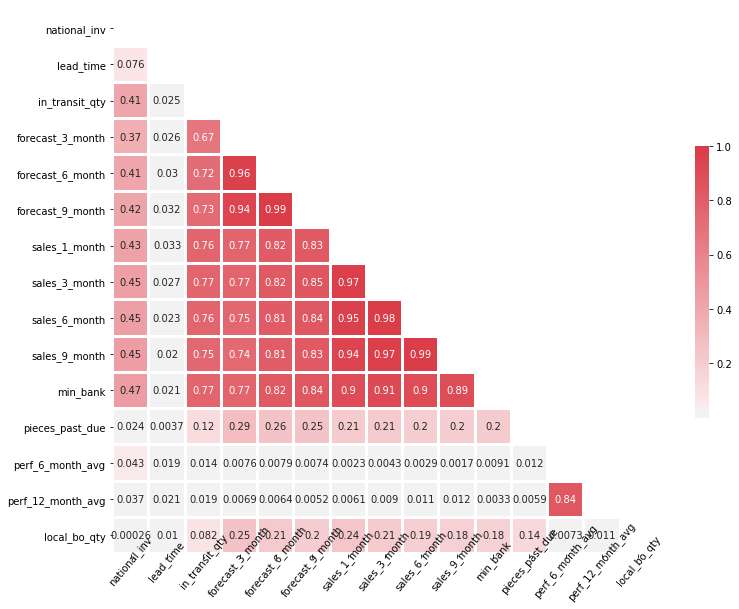

In [31]:
import seaborn as sns
# Compute the correlation matrix

corr = num_cols.corr()
corr_final = np.abs(corr)



# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14,10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr_final, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=2, cbar_kws={"shrink": .5})

plt.xticks(rotation=50, fontsize="10", va="center")
#ax.set_xticks()
plt.show()

### Function declarations

In [35]:

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score


scores = pd.DataFrame(columns=['Model','Train_Accuracy','Train_Recall','Train_Precision','Train_F1_Score','Test_Accuracy','Test_Recall','Test_Precision','Test_F1_Score'])

def get_metrics(train_actual,train_predicted,test_actual,test_predicted,model_description,dataframe):
    train_accuracy = accuracy_score(train_actual,train_predicted)
    train_recall   = recall_score(train_actual,train_predicted)
    train_precision= precision_score(train_actual,train_predicted)
    train_f1score  = f1_score(train_actual,train_predicted)
    test_accuracy = accuracy_score(test_actual,test_predicted)
    test_recall   = recall_score(test_actual,test_predicted)
    test_precision= precision_score(test_actual,test_predicted)
    test_f1score  = f1_score(test_actual,test_predicted)
    dataframe = dataframe.append(pd.Series([model_description, train_accuracy,train_recall,train_precision,train_f1score,
                                            test_accuracy,test_recall,test_precision,test_f1score],
                                           index=scores.columns ), ignore_index=True)
    return(dataframe)

In [36]:
from sklearn.metrics import classification_report


def classifcation_report_train_test(y_train, y_train_pred, y_test, y_test_pred):

    print('''
            =========================================
               CLASSIFICATION REPORT FOR TRAIN DATA
            =========================================
            ''')
    print(classification_report(y_train, y_train_pred))

    print('''
            =========================================
               CLASSIFICATION REPORT FOR TEST DATA
            =========================================
            ''')
    print(classification_report(y_test, y_test_pred))

## 1) SVC on Rawdata

## Plain SVC

In [37]:
## Build a SVM Classifier
from sklearn.svm import SVC

## Create an SVC object and print it to see the default arguments

svc = SVC()
svc

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [38]:
## Fit X_train,X_test,y_train,y_test

svc.fit(X_train1,y_train1)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [42]:
# Predict

y_train_pred_svc1 = svc.predict(X_train1)
y_test_pred_svc1 = svc.predict(X_test1)

y_train_pred_svc1.var
y_train1.

<bound method Series.var of 3248    0
7131    0
5007    0
6001    0
6957    1
2844    0
8379    0
5113    0
709     0
4251    0
7690    0
1324    0
1138    0
136     0
1808    1
8479    0
4910    0
8905    0
4487    1
4731    1
4097    0
6417    0
8030    0
7714    0
3418    0
4500    0
4750    0
3754    0
5302    0
6180    1
       ..
4934    0
9731    0
4057    0
6987    1
4808    0
9164    1
7522    0
8348    0
7745    0
5622    0
4059    1
4215    0
1093    0
8395    0
3141    0
3796    0
8159    0
9732    0
7523    0
6643    0
5996    0
2265    0
4956    0
8772    0
2541    0
6260    0
9843    0
1762    0
6246    0
8044    0
Name: went_on_backorder, Length: 7081, dtype: category
Categories (2, int64): [0, 1]>

In [43]:
scores = get_metrics(y_train1,y_train_pred_svc1,y_test1,y_test_pred_svc1,"Plain SVC with Clipping1",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,Plain SVC with Clipping1,0.964977,0.860656,0.949836,0.903049,0.83004,0.255495,0.756098,0.38193
1,Plain SVC with Clipping1,0.964977,0.860656,0.949836,0.903049,0.83004,0.255495,0.756098,0.38193


In [112]:
# Classification Report

classifcation_report_train_test(y_train1, y_train_pred_svc1, y_test1, y_test_pred_svc1)


               CLASSIFICATION REPORT FOR TRAIN DATA
            
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      5724
          1       0.96      0.88      0.92      1357

avg / total       0.97      0.97      0.97      7081


               CLASSIFICATION REPORT FOR TEST DATA
            
             precision    recall  f1-score   support

          0       0.85      0.98      0.91      1422
          1       0.77      0.27      0.40       349

avg / total       0.83      0.84      0.81      1771



## SVC implementation by setting class_weight = balance

In [116]:
# SVC implementation with class_weight as balanced or svc_balanced = SVC(class_weight={0:0.1,1:0.9})
svc_balanced = SVC(class_weight="balanced")

In [118]:
# Fit 
svc_balanced.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [119]:
# Predict

y_train_pred_bal = svc_balanced.predict(X_train)
y_test_pred_bal = svc_balanced.predict(X_test)

In [120]:
scores = get_metrics(y_train,y_train_pred_bal,y_test,y_test_pred_bal,"SVC with Class_weight as Balanced",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,Plain SVC with Clipping,0.968319,0.878303,0.951771,0.913562,0.845787,0.261708,0.805085,0.395010
1,Plain SVC with Clipping1,0.969072,0.878408,0.956661,0.915866,0.840203,0.269341,0.770492,0.399151
2,SVC with Class_weight as Balanced,0.958908,0.972879,0.837725,0.900257,0.842607,0.396694,0.648649,0.492308


In [45]:
# Classification Report

classifcation_report_train_test(y_train, , y_test, y_test_pred_bal)


               CLASSIFICATION REPORT FOR TRAIN DATA
            
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      6103
           1       0.84      0.97      0.90      1441

   micro avg       0.96      0.96      0.96      7544
   macro avg       0.92      0.96      0.94      7544
weighted avg       0.96      0.96      0.96      7544


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1527
           1       0.61      0.36      0.45       360

   micro avg       0.83      0.83      0.83      1887
   macro avg       0.74      0.65      0.68      1887
weighted avg       0.82      0.83      0.82      1887



In [46]:
## Use Grid Search for parameter tuning

from sklearn.model_selection import GridSearchCV

svc_grid = SVC(class_weight='balanced',random_state=1234)
 

param_grid = {

'C': [0.001, 0.01, 0.1, 1, 10],
'gamma': [0.001, 0.01, 0.1, 1], 
'kernel':['linear', 'rbf']}

 
svc_cv_grid = GridSearchCV(estimator = svc_grid, param_grid = param_grid, cv = 10,scoring='recall',n_jobs=-1,
                          verbose=3)

In [47]:
param_grid = {

'C': [9.3,9.4,9.5,9.6],
'gamma': [0.48,0.49,0.5,0.51,0.52,0.53], 
'kernel':['linear', 'rbf']}

 
svc_cv_grid = GridSearchCV(estimator = svc_grid, param_grid = param_grid, cv = 10)

In [ ]:
# Fit the grid search model

svc_cv_grid.fit(X = , y = )

In [ ]:
# Display the best model

svc_cv_grid.

In [ ]:
# Obtain the predictions using the best model

y_train_pred_svc_best = svc_cv_grid.best_estimator_.(X_train)
y_test_pred_svc_best = svc_cv_grid.best_estimator_.predict()

In [ ]:
# Obtain the predictions using the best model

y_train_pred_svc_best = svc_cv_grid.predict()
y_test_pred_svc_best = svc_cv_grid.(X_test)

In [ ]:
scores = get_metrics(y_train,,y_test,y_test_pred_svc_best,"SVC with Tuning Parameters",scores)
scores

In [ ]:
# Classification Report

classifcation_report_train_test(y_train, y_train_pred_svc_best, y_test, y_test_pred_svc_best)

In [ ]:
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, y_train, X_test, y_test, svc, scoring='recall')